# Run Model Bias Analysis with SageMaker Clarify (Post-Training)

## Using SageMaker Processing Jobs

In [1]:
import boto3
import sagemaker
import pandas as pd
import numpy as np

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

# Show inference.py

## _Note: Model needs to return JSONLINES to parse prediction result with Clarify_

In [2]:
!pygmentize ./src/inference.py

import json
import subprocess
import sys
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'tensorflow==2.3.1'])
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'transformers==4.1.1'])
# Workaround for https://github.com/huggingface/tokenizers/issues/120 and
#                https://github.com/kaushaltrivedi/fast-bert/issues/174
#subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--upgrade', 'tokenizers'])

import tensorflow as tf
from transformers import DistilBertTokenizer

classes=[1, 2, 3, 4, 5]

max_seq_length=64

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def input_handler(data, context):
    data_str = data.read().decode('utf-8')
    print('data_str: {}'.format(data_str))

    data_json = json.loads(data_str)
    print('data_json: {}'.format(data_json))

    transformed_instances = []

    for data_json_line in data_json:
        print('data_json_line: {}'.format(data_json_line))
        print('type(data_j

# Get Data

In [19]:
import pandas as pd

data = pd.read_json('data-clarify/amazon_reviews_us_giftcards_software_videogames_balanced.jsonl', lines=True)
data.shape

(2, 3)

In [20]:
data.head()

,star_rating,product_category,review_body
0,5,Gift Card,"i like the gift cards, if you need something q..."
1,1,Digital_Software,I downloaded this product and installed it on ...


### Data inspection
Plotting histograms for the distribution of the different features is a good way to visualize the data. Let's plot a few of the features that can be considered _sensitive_.  
Let's take a look specifically at the Sex feature of a census respondent. In the first plot we see that there are fewer Female respondents as a whole but especially in the positive outcomes, where they form ~$\frac{1}{7}$th of respondents.

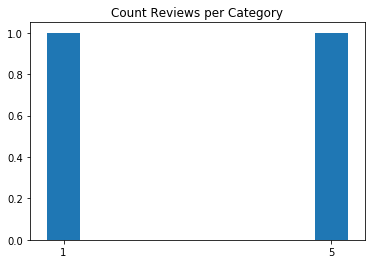

In [21]:
data['star_rating'].value_counts().sort_values().plot(kind='bar', title='Count Reviews per Category', rot=0)

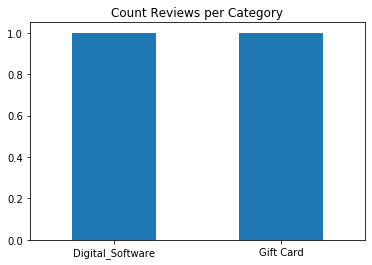

In [22]:
data['product_category'].value_counts().sort_values().plot(kind='bar', title='Count Reviews per Category', rot=0)

# Create Model

In [23]:
%store -r training_job_name

In [24]:
print(training_job_name)

tensorflow-training-2021-01-23-15-39-48-353


In [25]:
import sagemaker

inference_image_uri = sagemaker.image_uris.retrieve(
    framework="tensorflow",
    region=region,
    version="2.3.1",
    py_version="py37",
    instance_type='ml.m5.4xlarge',
    image_scope="inference"
)
print(inference_image_uri)

763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-inference:2.3.1-cpu


In [26]:
try:
    model_name = sess.create_model_from_job(
        training_job_name=training_job_name,
        image_uri=inference_image_uri
    )
except:
    pass

Using already existing model: tensorflow-training-2021-01-23-15-39-48-353


In [27]:
print(model_name)

tensorflow-training-2021-01-23-15-39-48-353


# Detecting Bias with Amazon SageMaker Clarify

SageMaker Clarify helps you detect possible pre- and post-training biases using a variety of metrics.

In [28]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(role=role,
                                                      instance_count=1,
                                                      instance_type='ml.c5.2xlarge',
                                                      sagemaker_session=sess)

# Post-training Bias
Computing post-training bias metrics does require a trained model.

Unbiased training data (as determined by concepts of fairness measured by bias metric) may still result in biased model predictions after training. Whether this occurs depends on several factors including hyperparameter choices.


You can run these options separately with `run_pre_training_bias()` and `run_post_training_bias()` or at the same time with `run_bias()` as shown below.

## Writing DataConfig and ModelConfig
A `DataConfig` object communicates some basic information about data I/O to Clarify. We specify where to find the input dataset, where to store the output, the target column (`label`), the header names, and the dataset type.

Similarly, the `ModelConfig` object communicates information about your trained model and `ModelPredictedLabelConfig` provides information on the format of your predictions.  

**Note**: To avoid additional traffic to your production models, SageMaker Clarify sets up and tears down a dedicated endpoint when processing. `ModelConfig` specifies your preferred instance type and instance count used to run your model on during Clarify's processing.

In [29]:
post_train_dataset = data[['star_rating', 'product_category', 'review_body']]

In [30]:
post_train_dataset.head()

,star_rating,product_category,review_body
0,5,Gift Card,"i like the gift cards, if you need something q..."
1,1,Digital_Software,I downloaded this product and installed it on ...


# Select n samples across each category

## _Note: We need to have >1 product_categories (facet values) in our training data._

In [31]:
test_data = post_train_dataset.groupby('product_category', group_keys=False).apply(lambda s: s.sample(1))
test_data.reset_index(drop=True, inplace=True)
test_data.shape

(2, 3)

In [32]:
test_data.head()

,star_rating,product_category,review_body
0,1,Digital_Software,I downloaded this product and installed it on ...
1,5,Gift Card,"i like the gift cards, if you need something q..."


# Convert To Categorical dtype

## _Note: Otherwise Clarify converts (int) and (str) to continuous threshold values instead of categorial values._

In [33]:
test_data['product_category'] = test_data['product_category'].astype('category')

In [34]:
test_data['product_category'].dtype

CategoricalDtype(categories=['Digital_Software', 'Gift Card'], ordered=False)

In [35]:
test_data['star_rating'] = test_data['star_rating'].astype('category')

In [36]:
test_data['star_rating'].dtype

CategoricalDtype(categories=[1, 5], ordered=False)

# Convert to `jsonlines` Format and Upload To S3

In [37]:
path = './data-clarify/post_train_data.jsonl'
test_data.to_json(path, orient="records", lines=True)

In [38]:
# path = './post_train_data.csv'
# test_data.to_csv(path, index=False, header=True)

In [39]:
# TODO:  Make this prefix more unique, if possible.  Perhaps use $bucket/$training_job_name/data-clarify/post_train_data.jsonlines
s3_prefix = 'data'
post_train_dataset_s3_uri = sess.upload_data(bucket=bucket, key_prefix=training_job_name, path=path)
post_train_dataset_s3_uri

's3://sagemaker-us-east-1-231218423789/tensorflow-training-2021-01-23-15-39-48-353/post_train_data.jsonl'

In [40]:
# s3_prefix = 'data'
# post_train_dataset_s3_uri = sess.upload_data(path=path_jsonlines, key_prefix=s3_prefix)
# post_train_dataset_s3_uri

# Configure Clarify

In [46]:
bias_report_output_path = 's3://{}/clarify-bias'.format(bucket)

data_config = clarify.DataConfig(s3_data_input_path=post_train_dataset_s3_uri,
                                 s3_output_path=bias_report_output_path,
                                 label='star_rating',
                                 features='review_body',
                                 headers=post_train_dataset.columns.to_list(),
                                 dataset_type='application/jsonlines')

In [47]:
bias_config = clarify.BiasConfig(label_values_or_threshold=[5,4], # needs to be int or str for continuous dtype, needs to be >1 for categorical dtype
                                facet_name='product_category',
                                facet_values_or_threshold=['Gift Card'],
                                group_name='product_category')

In [48]:
model_config = clarify.ModelConfig(model_name=model_name,
                                   instance_type='ml.m5.4xlarge',
                                   instance_count=1,
                                   content_type='application/jsonlines',
                                   accept_type='application/jsonlines',
                                   content_template='{\"review_body\":$features}'
                                  )

#"{\"myfeatures\":$features}"

## _Note: `label` is set to the JSON key for the model prediction results_

In [49]:
predictions_config = clarify.ModelPredictedLabelConfig(label='predicted_label')

## Run Clarify

In [50]:
clarify_processor.run_post_training_bias(
    data_config=data_config,
    data_bias_config=bias_config,
    model_config=model_config,
    model_predicted_label_config=predictions_config,
#    methods='all', # FlipTest requires all columns to be numeric
    methods=['DPPL', 'DI', 'DCA', 'DCR', 'RD', 'DAR', 'DRR', 'AD', 'CDDPL', 'TE'],
    wait=True)


Job Name:  Clarify-Posttraining-Bias-2021-01-23-19-56-03-575
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-231218423789/tensorflow-training-2021-01-23-15-39-48-353/post_train_data.jsonl', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-231218423789/Clarify-Posttraining-Bias-2021-01-23-19-56-03-575/input/analysis_config/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-231218423789/clarify-bias', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': '

UnexpectedStatusException: Error for Processing job Clarify-Posttraining-Bias-2021-01-23-19-56-03-575: Failed. Reason: ClientError: Dataset must contain features


#### Viewing the Bias Report
In Studio, you can view the results under the experiments tab.

<img src="img/bias_report.gif">

Each bias metric has detailed explanations with examples that you can explore.

<img src="img/bias_detail.gif">

You could also summarize the results in a handy table!

<img src="img/bias_report_chart.gif">


If you're not a Studio user yet, you can access the bias report in pdf, html and ipynb formats in the following S3 bucket:

# Download Report From S3

In [ ]:
!aws s3 ls $bias_report_output_path/

In [ ]:
!aws s3 cp $bias_report_output_path/report.html ./bias_report.html